In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from nn.tensor import Tensor
from nn.optimizer import RMSPropOptimizer, AdamOptimizer

In [12]:
def quadratic_form(x1, x2):
    A = [
        [16, 8], 
        [-24, 32]
    ]
    x = [x1, x2]
    return sum(A[i][j] * x[i] * x[j] for i in range(2) for j in range(2))

DOMAIN = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-5, 5, 100), indexing='ij')

In [13]:
def get_path_for_pytorch(x1_init: float, x2_init: float, num_iters: int, optimizer_class: type, **kwargs):
    x1, x2 = torch.tensor(x1_init, dtype=torch.float64), torch.tensor(x2_init, dtype=torch.float64)
    x1.requires_grad_()
    x2.requires_grad_()

    optimizer = optimizer_class([x1, x2], **kwargs)

    path = [(x1.item(), x2.item())]

    for _ in range(num_iters):
        optimizer.zero_grad()

        loss = quadratic_form(x1, x2)

        loss.backward()

        optimizer.step()

        path.append((x1.item(), x2.item()))

    return path

def get_path_for_nn(x1_init: float, x2_init: float, num_iters: int, optimizer_class: type, **kwargs):
    x1 = Tensor(x1_init)
    x2 = Tensor(x2_init)

    optimizer = optimizer_class([x1, x2], **kwargs)

    path = [(x1.data, x2.data)]
    for _ in range(num_iters):
        objective = quadratic_form(x1, x2)
        optimizer.zero_grad()
        objective.back_prop()
        optimizer.step()
        path.append((x1.data, x2.data))

    return path


In [14]:
def draw_contour(ax):
    values = quadratic_form(DOMAIN[0], DOMAIN[1])

    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.contour(DOMAIN[0], DOMAIN[1], values, 10)
    minimum = np.argmin(values.reshape(-1))
    minimum = minimum // values.shape[1], minimum % values.shape[1]
    minimum = DOMAIN[0][minimum], DOMAIN[1][minimum]
    ax.scatter([minimum[0]], [minimum[1]], color='red')
    ax.axis('scaled');

def draw_path(ax, path):
    for start, end in zip(path[:-1], path[1:]):
        ax.arrow(*start, *map(lambda s, e: e - s, start, end), head_width=0.01, head_length=0.01, color='black')

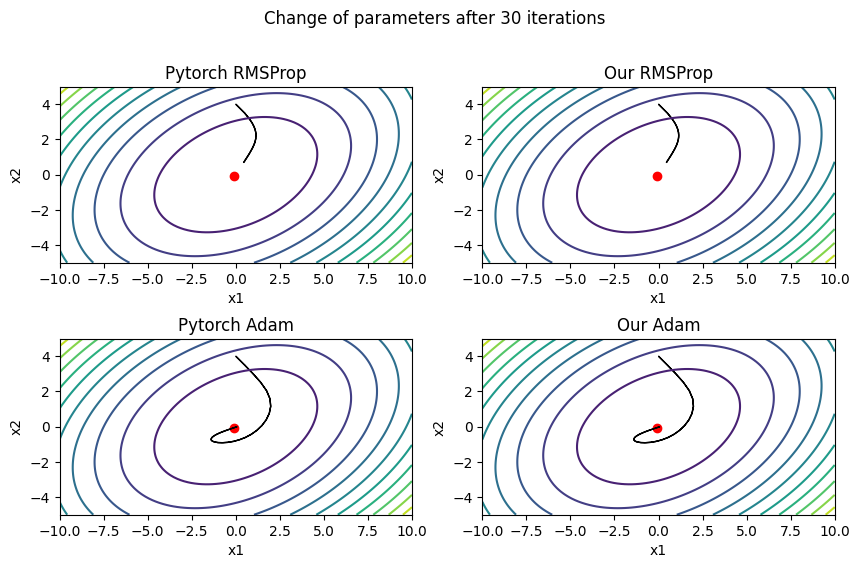

In [15]:
num_iters = 30

fig = plt.figure(figsize=(10, 6))
fig.suptitle(f"Change of parameters after {num_iters} iterations")

optimizers = [
    ('RMSProp', torch.optim.RMSprop, {'lr': 0.05, 'alpha': 0.99, 'eps': 1e-08}, RMSPropOptimizer, {'lr': 0.05, 'alpha': 0.99, 'eps': 1e-08}),
    ('Adam', torch.optim.Adam, {'lr': 0.5}, AdamOptimizer, {'lr': 0.5})
    ]
axis = fig.subplots(len(optimizers), 2)

for (name, torch_optim, torch_params, our_optim, our_params), (ax1, ax2) in zip(optimizers, axis):
    ax1.set_title(f"Pytorch {name}")
    ax2.set_title(f"Our {name}")

    draw_contour(ax1)
    draw_path(ax1, get_path_for_pytorch(0, 4, num_iters, torch_optim, **torch_params))
    draw_contour(ax2)
    draw_path(ax2, get_path_for_nn(0, 4, num_iters, our_optim, **our_params))

**Conclusion**: Our implementations of Adam and RMSProp perform equivalently to those of Pytorch